In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import precision_score, classification_report, confusion_matrix
import joblib
import os

current_dir = os.getcwd()
if current_dir.endswith("notebooks"):
    project_root = os.path.dirname(current_dir)
elif current_dir.endswith("signal_synthesiser"):
    project_root = current_dir
else:
    project_root = os.path.dirname(current_dir)

data_path = os.path.join(project_root, "data", "processed", "labelled_data.csv")

if os.path.exists(data_path):
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    print(f"Data Loaded. Shape: {df.shape}")
else:
    print("Error: Data not found. Run 01_data_prep first.")


Data Loaded. Shape: (2161, 24)


In [9]:
# Time-Series Split
train_end = "2020-01-01"
val_end = "2022-01-01"

train = df[df.index < train_end]
val = df[(df.index >= train_end) & (df.index < val_end)]
test = df[df.index >= val_end]

print(f"Training Set:   {train.shape[0]} days")
print(f"Validation Set: {val.shape[0]} days")

Training Set:   1160 days
Validation Set: 505 days


In [10]:
# Feature Definition
features = [
    'Signal_RSI', 'Signal_Trend', 'Signal_MACD', 'Signal_Bollinger', # Strategies
    'Volatility', 'VIX_Norm', 'Is_Friday', 'Volume'                  # Context
]
target = 'Target_Label'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [11]:
# Train XGBoost 
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)

model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1, 
    max_depth=5,         
    scale_pos_weight=ratio,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

print(f"Training XGBoost with Class Ratio: {ratio:.2f}...")
model.fit(X_train, y_train)
print("Training Complete.")


Training XGBoost with Class Ratio: 2.56...


/mnt/c/Users/sohan/Projects/signal_synthesiser/venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:08:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training Complete.


XGBoost Precision: 63.55%

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.73      0.71       279
           1       0.64      0.57      0.60       226

    accuracy                           0.66       505
   macro avg       0.66      0.65      0.65       505
weighted avg       0.66      0.66      0.66       505



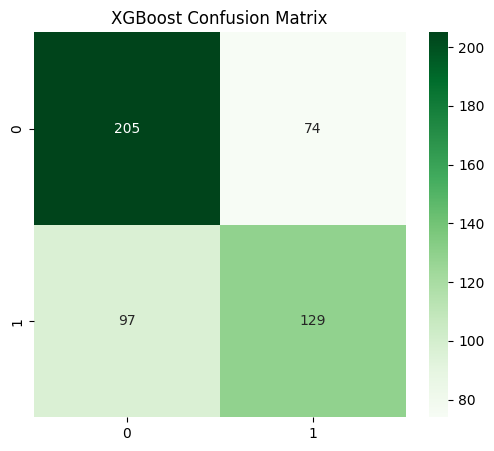

In [12]:
# Evaluation
preds = model.predict(X_val)
precision = precision_score(y_val, preds)

print(f"XGBoost Precision: {precision:.2%}")
print("\nClassification Report:")
print(classification_report(y_val, preds))

# Confusion Matrix
cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost Confusion Matrix')
plt.show()

<Figure size 1000x600 with 0 Axes>

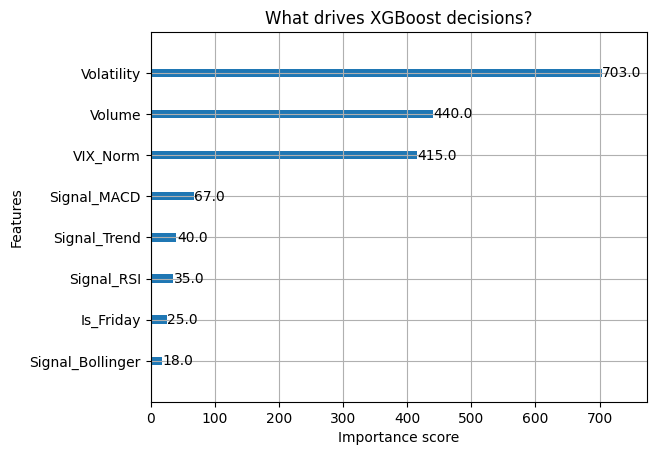

In [13]:
# Feature Importance
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type='weight', title='What drives XGBoost decisions?')
plt.show()

In [15]:
# Save Model
save_dir = os.path.join(project_root, "models")
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "xgb_v1.joblib")
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

Model saved to /mnt/c/Users/sohan/Projects/signal_synthesiser/models/xgb_v1.joblib
